## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *

In [2]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(189)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 32
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [6]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [7]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1957, 4667, 1863, 731, 4373, 1709, 2682, 2319, 3849]


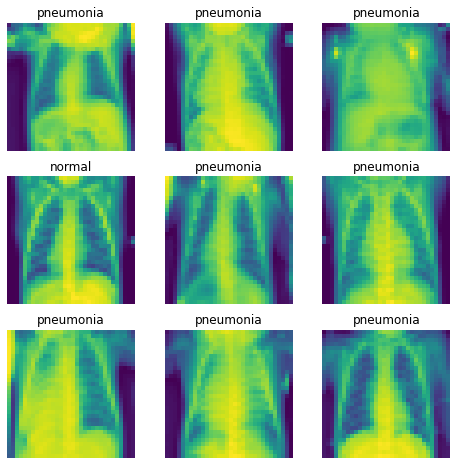

In [9]:
visualize_data(train_data)

[247, 226, 37, 287, 481, 398, 21, 583, 580]


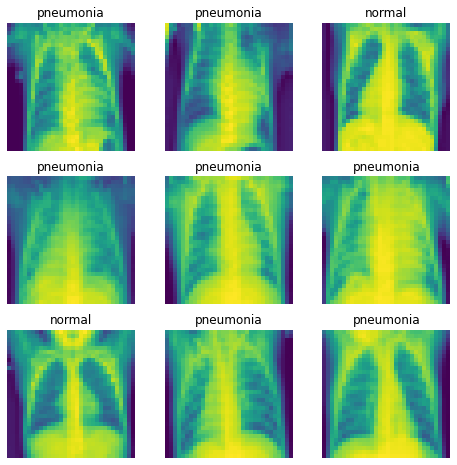

In [10]:
visualize_data(test_data)

## Model Definition

In [11]:
class DeepLearnConv(torch.nn.Module):
    def __init__(self, inputs, outputs, weights, kernel_size):
        super(DeepLearnConv, self).__init__()
        
        self.conv = nn.Conv2d(inputs, outputs, kernel_size = kernel_size)
        with torch.no_grad():
            self.conv.weight = nn.Parameter(weights)
        self.batch_norm = nn.BatchNorm2d(outputs)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x

In [12]:
class DeepLearnLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepLearnLinear, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        nn.init.xavier_uniform_(self.linear.weight)
        self.batch_norm = nn.BatchNorm1d(outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x

In [13]:
class DeepLearn(torch.nn.Module):
    def __init__(self, kernels, hidden, kernel_size, window, hidden_linear, labels):
        super(DeepLearn, self).__init__()
        
        self.kernels = kernels
        self.conv = [DeepLearnConv(hidden[i], hidden[i+1], 
                                    self.kernels[i].view(1, 1, 3, 3).repeat(hidden[i+1], hidden[i], 1, 1), 
                                    kernel_size) for i in range(len(hidden)-1)]
        self.conv_combined = nn.Sequential(*self.conv)
        
        self.maxpool = nn.MaxPool2d(window)
        self.flattened = hidden_linear[0]
        self.linear= [DeepLearnLinear(hidden_linear[i], hidden_linear[i+1]) for i in range(len(hidden_linear)-1)]
        self.linear_combined = nn.Sequential(*self.linear)
        
        self.output = nn.Linear(hidden_linear[-1], labels)
    
    def forward(self, x):
        x = self.conv_combined(x)
        x = self.maxpool(x)
        x = x.view(-1, self.flattened)
        x = self.linear_combined(x)
        x = self.output(x)
        return x

## AutoEncoder Definition

In [14]:
class Encoder(torch.nn.Module):
    
    def __init__(self,inputs,outputs,kernel):
        super(Encoder, self).__init__()
        
        self.conv=nn.Conv2d(inputs, outputs,kernel_size=kernel)
        self.batchnorm=nn.BatchNorm2d(outputs)
        self.relu=nn.LeakyReLU()
        
    def forward(self,x):
        x=self.conv(x)
        x=self.batchnorm(x)
        x=self.relu(x)
        return x

In [15]:
class Decoder(torch.nn.Module):
    
    def __init__(self,inputs,outputs,kernel):
        super(Decoder,self).__init__()
        self.convt=nn.ConvTranspose2d(inputs,outputs,kernel_size=kernel)
        self.batchnorm=nn.BatchNorm2d(outputs)
        self.relu=nn.ReLU()
        
    def forward(self,x):
        x=self.convt(x)
        x=self.batchnorm(x)
        x=self.relu(x)
        return x

In [16]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, hidden, kernel_size):
        super(AutoEncoder,self).__init__()
        self.enc= [Encoder(hidden[i], hidden[i+1], kernel_size) for i in range(len(hidden)-1)]
        self.enc_combined = nn.Sequential(*self.enc)

        self.dec= [Decoder(hidden[i], hidden[i-1], kernel_size) for i in range(len(hidden)-1, 0, -1)]
        self.dec_combined = nn.Sequential(*self.dec)
        
    def forward(self,x):
        x=self.enc_combined(x)
        x=self.dec_combined(x)
        return x
    
    def get_features(self, x):
        return self.enc_combined(x)

## Initialise Model

In [18]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [23]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [128, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (26-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]
labels = 2

In [24]:
model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                       hidden_linear=hidden_linear, labels=labels).to(device)
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepLearnConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=6400, out_features=512, bias=True)
 

## Load AutoEncoder

In [25]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128]

# kernel size of convolution layers
kernel_size_a = 3

In [26]:
autoencmodel=AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoenc_latest")["model_state_dict"])

<All keys matched successfully>

In [27]:
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Sequential(
    (0): Decoder(
      (convt): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1)

In [28]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [29]:
optimizer = create_adam_optimizer(model)

In [185]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 1, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.921875
Epoch 1/1, Batch number: 5, Cumulated accuracy: 0.9427083333333334
Epoch 1/1, Batch number: 10, Cumulated accuracy: 0.9467329545454546
Epoch 1/1, Batch number: 15, Cumulated accuracy: 0.944580078125
--- Epoch 1/1: Train loss: 0.1537, Train accuracy: 0.9434
--- Epoch 1/1: Val loss: 0.2707, Val accuracy: 0.9162


## Testing Model & Performance Curves

In [186]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.3275, Test accuracy: 0.8923


Precision: 0.9044444444444445
Recall: 0.9531615925058547
F1 score: 0.9281641961231469


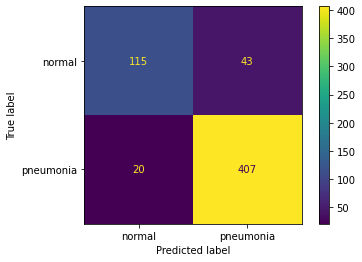

In [187]:
show_metrics(true_labels, model_preds)

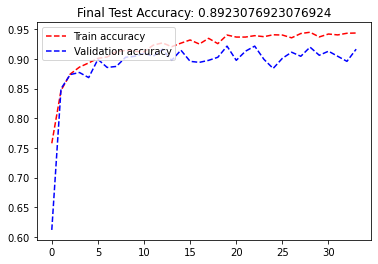

In [188]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

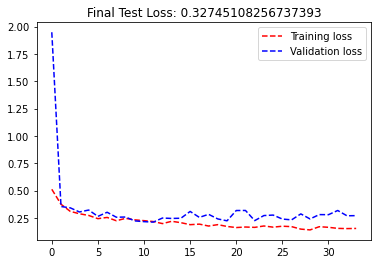

In [189]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './latest_939f1')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])